In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import functools
import numbers
from IPython import display
import time

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchvision
from PIL import Image
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms

from sklearn.metrics import f1_score

import os

import itertools
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix



size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)

def use_svg_display():
    """Use the svg format to display a plot in Jupyter.

    Defined in :numref:`sec_calculus`"""
    display.set_matplotlib_formats('svg')


class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib.

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class Timer:
    """Record multiple running times."""
    def __init__(self):
        """Defined in :numref:`subsec_linear_model`"""
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()


class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_softmax_scratch`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        self.num_axes = nrows * ncols
        if self.num_axes == 1:
            self.axes = [self.axes, ]
        xlabel = self._repeat_arg_if_not_iterable(xlabel)
        ylabel = self._repeat_arg_if_not_iterable(ylabel)
        legend = self._repeat_arg_if_not_nested_iterable(legend)
        xlim = self._repeat_arg_if_not_nested_iterable(xlim)
        ylim = self._repeat_arg_if_not_nested_iterable(ylim)
        xscale = self._repeat_arg_if_not_nested_iterable(xscale)
        yscale = self._repeat_arg_if_not_nested_iterable(yscale)
        # Bind arguments with functools
        self.config_axes = [functools.partial(set_axes, self.axes[i], xlabel[i], ylabel[i], 
            xlim[i], ylim[i], xscale[i], yscale[i], legend[i]) for i in range(self.num_axes)]
        self.fmts = fmts
        self.X, self.Y = [None] * self.num_axes, [None] * self.num_axes

    def add(self, x, y):
        if self.num_axes == 1:
            x = [x,]
            y = [y,]
        x = self._repeat_arg_if_not_iterable(x)
        y = self._repeat_arg_if_not_iterable(y)
        for ax_idx, (ax, config_ax, ax_x, ax_y) in enumerate(zip(self.axes, self.config_axes, x, y)):
            # Add multiple data points into the figure
            if not hasattr(ax_y, "__len__"):
                ax_y = [ax_y]
            n = len(ax_y)
            if not hasattr(ax_x, "__len__"):
                ax_x = [ax_x] * n
            if not self.X[ax_idx]:
                self.X[ax_idx] = [[] for _ in range(n)]
            if not self.Y[ax_idx]:
                self.Y[ax_idx] = [[] for _ in range(n)]
            for i, (a, b) in enumerate(zip(ax_x, ax_y)):
                if a is not None and b is not None:
                    self.X[ax_idx][i].append(a)
                    self.Y[ax_idx][i].append(b)
            ax.cla()
            for x, y, fmt in zip(self.X[ax_idx], self.Y[ax_idx], self.fmts):
                ax.plot(x, y, fmt)
            config_ax()
        display.display(self.fig)
        display.clear_output(wait=True)

    def _repeat_arg_if_not_iterable(self, arg):
        if arg is None or isinstance(arg, (str, numbers.Number)):
            return [arg] * self.num_axes
        else:
            return arg

    def _repeat_arg_if_not_nested_iterable(self, arg):
        if arg is None or isinstance(arg, str) or isinstance(arg[0], (numbers.Number, str)):
            return [arg] * self.num_axes
        else:
            return arg

def get_dataloader_workers():
    """Use 4 processes to read the data.

    Defined in :numref:`sec_fashion_mnist`"""
    return 4


def accuracy(y_hat, y):
    """Compute the number of correct predictions.

    Defined in :numref:`sec_softmax_scratch`"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = argmax(y_hat, axis=1)
    cmp = astype(y_hat, y.dtype) == y
    return float(reduce_sum(astype(cmp, y.dtype)))


def evaluate_accuracy_gpu(net, data_iter, feature_extractor, device=None):
    """Compute the accuracy for a model on a dataset using a GPU.

    Defined in :numref:`sec_lenet`"""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            #if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
               # X = [x.to(device) for x in X]
            #else:
                #X = X.to(device)
            x=X
                
            # Change input array into list with each batch being one element
            x = np.split(np.squeeze(np.array(x)), X.shape[0])
            # Remove unecessary dimension
            for index, array in enumerate(x):
                x[index] = np.squeeze(array)
            # Apply feature extractor, stack back into 1 tensor and then convert to tensor
            x = torch.tensor(np.stack(feature_extractor(x)['pixel_values'], axis=0))
            # Send to GPU if available
            x, y  = x.to(device), y.to(device)
            
            
            y_hat, _ = net(x,y)
            
            
            metric.add(accuracy(y_hat, y), size(y))
    return metric[0] / metric[1]


def evaluate_f1_gpu(net, data_iter, feature_extractor, device=None):
    """Compute the f1 score for a model on a dataset using a GPU.

    Defined in :numref:`sec_lenet`"""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions

    
    y_tot =[]
    y_hat_tot = []

    with torch.no_grad():
        for X, y in data_iter:
            #if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
               # X = [x.to(device) for x in X]
            #else:
                #X = X.to(device)
            x=X
                
            # Change input array into list with each batch being one element
            x = np.split(np.squeeze(np.array(x)), X.shape[0])
            # Remove unecessary dimension
            for index, array in enumerate(x):
                x[index] = np.squeeze(array)
            # Apply feature extractor, stack back into 1 tensor and then convert to tensor
            x = torch.tensor(np.stack(feature_extractor(x)['pixel_values'], axis=0))
            # Send to GPU if available
            x, y  = x.to(device), y.to(device)
            
            
            y_hat, _ = net(x,y)
            
            y_tot  += y.cpu().data.numpy().tolist()
            y_hat_tot += argmax(y_hat.cpu(), axis=1).data.numpy().tolist()
            
    f1_measure = f1_score(y_tot, y_hat_tot, average="macro")
            

    return f1_measure, y_tot, y_hat_tot



In [2]:
class myDataset_1(torch.utils.data.Dataset):
    """My dataset."""
    def __init__(self, images, labels):
        """
        Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        """
        self.labels = labels
        self.images = images
        #self.root_dir = root_dir
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        # read image
        #img_name = os.path.join(self.root_dir, self.labels.iloc[idx, 0])
        image = torch.tensor(self.images[idx]).float()
        # read labels
        labels = torch.tensor(self.labels[idx]).long()
        sample = [image, labels]
        return sample

In [3]:
Y_lbs = np.load('train_y.npy')

In [4]:
train_ds = myDataset_1(np.load('train_x.npy'), Y_lbs)
valid_ds = myDataset_1(np.load('val_x.npy'), np.load('val_y.npy'))


In [4]:
class_weights = sklearn.utils.class_weight.compute_class_weight('balanced',np.unique(Y_lbs),Y_lbs)
class_weights=torch.tensor(class_weights,dtype=torch.float)
class_weights

D:\Data\Work\COGNIUS\platformtest\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1 2 3 4 5], y=[4 0 5 ... 0 4 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


tensor([0.9572, 1.2809, 1.0558, 1.0637, 0.7433, 1.0616])

In [5]:
from transformers import ViTModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch.nn.functional as F

class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=6):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        if loss is not None:
            return logits, loss.item()
        else:
            return logits, None

In [6]:
EPOCHS = 2
BATCH_SIZE = 512
LEARNING_RATE = 1e-5

In [7]:
from transformers import ViTFeatureExtractor
import torch.nn as nn
import torch
# Define Model
model = ViTForImageClassification(6)    
# Feature Extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Use GPU if available  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

# Cross Entropy Loss
loss_func = nn.CrossEntropyLoss(weight=class_weights.to(device),reduction='mean')

if torch.cuda.is_available():
    model.cuda()

In [8]:
device

device(type='cuda')

In [10]:
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np

print("Number of train samples: ", len(train_ds))
print("Number of test samples: ", len(valid_ds))
print("Detected Classes are: ", 6) 

train_loader = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = data.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=True) 

#train_loader,test_loader = load_data_k_mnist(BATCH_SIZE, resize=32)

print("came here 1")



Number of train samples:  52908
Number of test samples:  8648
Detected Classes are:  6
came here 1


In [11]:
def trainf(net, feature_extractor, train_iter, test_iter, loss_func, num_epochs, optimizer, device, scheduler=None, ylim=(None, (0, 1))):
    """Train and evaluate a model with CPU or GPU."""
    net.to(device)
    animator = Animator(xlabel='epoch', xlim=[0, num_epochs], ylim=ylim,
                        legend=[['train loss'], ['train acc', 'train f1', 'val acc', 'val f1'] ],
                        nrows=1, ncols=2, figsize=(10, 4))
    
    animator.add(0, [None, (0, 0, 0, 0)])
    column_names=["Epoch", "Training Loss", "Training Accuracy", "Training F1 Score", "Validation Accuracy", "Validation F1 Score"]
    
    metric_dict =  pd.DataFrame([[0,0,0,0,0,0]], columns=column_names)
    timer = Timer()
    for epoch in range(num_epochs):
        metric = Accumulator(4)  # train_loss, train_acc, train_f1, num_examples
        for i, (X, y) in enumerate(train_iter):
            x=X
            timer.start()
            net.train()
            
            # Change input array into list with each batch being one element
            #print(X.shape[0])
            x = np.split(np.squeeze(np.array(x)), X.shape[0])
            # Remove unecessary dimension
            for index, array in enumerate(x):
                x[index] = np.squeeze(array)
            # Apply feature extractor, stack back into 1 tensor and then convert to tensor
            x = torch.tensor(np.stack(feature_extractor(x)['pixel_values'], axis=0))
            # Send to GPU if available
            x, y  = x.to(device), y.to(device)
            b_x = Variable(x)   # batch x (image)
            b_y = Variable(y)   # batch y (target)
            
            
            # Feed through model
            y_hat, loss = net(b_x, None)
            # Calculate loss
    
            if loss is None: 
                loss = loss_func(y_hat, b_y)   
                optimizer.zero_grad()           
                loss.backward()                 
                optimizer.step()
            
            
            with torch.no_grad():
                metric.add(loss*X.shape[0], accuracy(y_hat, y), f1_score(y.cpu(), argmax(y_hat.cpu(), axis=1), average='macro'), X.shape[0])
            timer.stop()
            train_loss, train_acc, train_f1 = metric[0]/metric[3], metric[1]/metric[3], metric[2]/(i+1)
            if (i+1) % 48 == 0:
                print(f'epoch {epoch:.0f}, step {(i+1):.0f}, training loss {train_loss:.5f}, train acc {train_acc:.5f}, train f1 {train_f1:.5f}'+'\n')
                animator.add(epoch + i/len(train_iter), [train_loss, (train_acc, train_f1, None, None)])

        if scheduler:
            scheduler.step()
        test_acc = evaluate_accuracy_gpu(net, test_iter, feature_extractor)
        test_f1, _, _ = evaluate_f1_gpu(net, test_loader, feature_extractor)
        #metric_dict[("Epoch "+str(epoch))] = 'training loss : '+str(round(train_loss, 5))+' ,train acc : '+str(round(train_acc, 5))+' ,train f1 : '+str(round(train_f1, 5))+' ,test acc : '+str(round(test_acc, 5)+' ,test f1 : '+str(round(test_f1, 5)))
        new_row = {"Epoch":epoch+1, "Training Loss":train_loss, "Training Accuracy":train_acc , "Training F1 Score":train_f1 , "Validation Accuracy":test_acc, "Validation F1 Score":test_f1}
        metric_dict = metric_dict.append(new_row, ignore_index=True)
        print(f'epoch {epoch:.0f}, training loss {train_loss:.5f}, train acc {train_acc:.5f}, train f1 {train_f1:.5f}, test acc {test_acc:.5f}, test f1 {test_f1:.5f}'+'\n')
        animator.add(epoch + 1, [None, (None, None, test_acc, test_f1)])
        
    

    print("")
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec 'f'on {str(device)}')
    print("")
    
    metric_dict = metric_dict.drop([0])
    
    return metric_dict
    
    


2.1 examples/sec on cuda



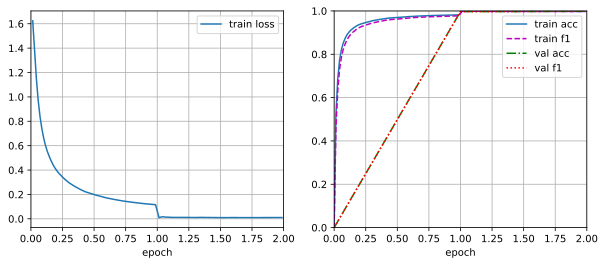

In [12]:
tr_df = trainf(model, feature_extractor, train_loader,test_loader , loss_func, EPOCHS, optimizer, device)

In [13]:
tr_df

,Epoch,Training Loss,Training Accuracy,Training F1 Score,Validation Accuracy,Validation F1 Score
1,1.0,0.114590,0.982007,0.977439,0.997225,0.996809
2,2.0,0.010656,0.997978,0.997243,0.998612,0.998366


In [14]:
torch.save(model, "model_1_2_1.pt")

In [8]:
#loading testing set

ds_test = myDataset_1(np.load('test_new_x.npy'), np.load('test_new_y.npy'))

In [9]:
test_loader  = data.DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
model = torch.load("model_1_2_1.pt")



In [11]:
model.load_state_dict(torch.load("model_main_vit_2/model_vit_main_2_state_dict.pt", map_location='cuda:0'))
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_fea

In [23]:
#evaluate_accuracy_gpu(model, test_loader, feature_extractor)

In [13]:
test_f1, y_t, y_h_t = evaluate_f1_gpu(model, test_loader, feature_extractor)

In [14]:
test_f1

0.906492180940802

In [15]:
all_f1s_test = f1_score(y_t, y_h_t, average=None)

In [16]:
all_f1s_test

array([0.96873598, 0.73317451, 0.97329377, 0.83600221, 0.94716949,
       0.98057714])

In [22]:
sklearn.metrics.accuracy_score(y_t, y_h_t)

0.9428877660388915

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="grey" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [18]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_t, y_h_t)
np.set_printoptions(precision=4)

In [19]:
cls_names = ['ANGER', 'DISGUST', 'FEAR', 'HAPPINESS', 'SADNESS', 'SURPRISE']

Confusion matrix, without normalization
[[ 3238     0     2    10   167    10]
 [    0  1231     1    27   135     0]
 [    0     0  1312    19     9    22]
 [    0     0     0   757     0     1]
 [   19   733    18    72 11026    71]
 [    1     0     1   168     6  7068]]


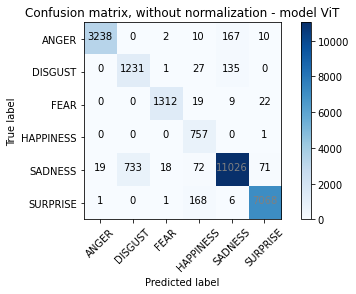

In [20]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=cls_names, title='Confusion matrix, without normalization - model ViT')
plt.show()
plt.close()


Normalized confusion matrix
[[0.945 0.    0.001 0.003 0.049 0.003]
 [0.    0.883 0.001 0.019 0.097 0.   ]
 [0.    0.    0.963 0.014 0.007 0.016]
 [0.    0.    0.    0.999 0.    0.001]
 [0.002 0.061 0.002 0.006 0.924 0.006]
 [0.    0.    0.    0.023 0.001 0.976]]


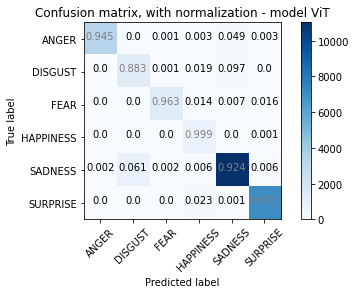

In [21]:
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, classes=cls_names, title='Confusion matrix, with normalization - model ViT')
plt.show()
plt.close()

In [24]:
model.load_state_dict(torch.load("vit_rmsprop_lr_0_00001/model_vit_RMSPROP_lr_0_00001_state_dict.pt", map_location='cuda:0'))
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_fea

In [25]:
#evaluate_accuracy_gpu(model, test_loader, feature_extractor)

In [26]:
test_f1, y_t, y_h_t = evaluate_f1_gpu(model, test_loader, feature_extractor)

In [27]:
test_f1

0.9081836299218757

In [28]:
all_f1s_test = f1_score(y_t, y_h_t, average=None)

In [29]:
all_f1s_test

array([0.9819, 0.7478, 0.9688, 0.8305, 0.9525, 0.9675])

In [30]:
sklearn.metrics.accuracy_score(y_t, y_h_t)

0.9453758995559639

In [31]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_t, y_h_t)
np.set_printoptions(precision=4)

In [32]:
cls_names = ['ANGER', 'DISGUST', 'FEAR', 'HAPPINESS', 'SADNESS', 'SURPRISE']

Confusion matrix, without normalization
[[ 3330     0     1     5    12    79]
 [    0  1124     4    59   202     5]
 [    0     0  1321    18     5    18]
 [    0     0     0   757     0     1]
 [   25   488    37    94 11057   238]
 [    1     0     2   132     1  7108]]


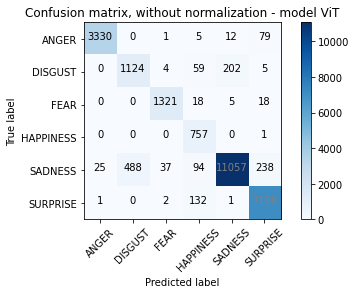

In [33]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=cls_names, title='Confusion matrix, without normalization - model ViT')
plt.show()
plt.close()

Normalized confusion matrix
[[0.972 0.    0.    0.001 0.004 0.023]
 [0.    0.806 0.003 0.042 0.145 0.004]
 [0.    0.    0.97  0.013 0.004 0.013]
 [0.    0.    0.    0.999 0.    0.001]
 [0.002 0.041 0.003 0.008 0.926 0.02 ]
 [0.    0.    0.    0.018 0.    0.981]]


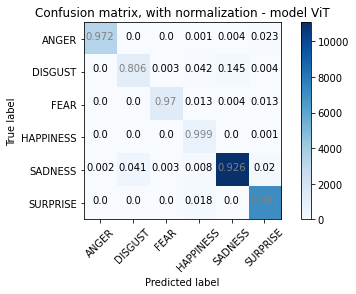

In [34]:
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, classes=cls_names, title='Confusion matrix, with normalization - model ViT')
plt.show()
plt.close()

In [47]:
model.load_state_dict(torch.load("vit_2_epochs/model_vit_main_epochs_2_state_dict.pt", map_location='cuda:0'))
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_fea

In [48]:
#evaluate_accuracy_gpu(model, test_loader, feature_extractor)

In [49]:
test_f1, y_t, y_h_t = evaluate_f1_gpu(model, test_loader, feature_extractor)

In [50]:
test_f1

0.8913226887867931

In [51]:
all_f1s_test = f1_score(y_t, y_h_t, average=None)

In [52]:
all_f1s_test

array([0.9551, 0.6844, 0.9701, 0.8374, 0.9337, 0.9672])

In [53]:
sklearn.metrics.accuracy_score(y_t, y_h_t)

0.9267340376665135

In [54]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_t, y_h_t)
np.set_printoptions(precision=4)

In [55]:
cls_names = ['ANGER', 'DISGUST', 'FEAR', 'HAPPINESS', 'SADNESS', 'SURPRISE']

Confusion matrix, without normalization
[[ 3138     0     4     8   134   143]
 [    0  1262     0    29    98     5]
 [    0     0  1300    31     6    25]
 [    0     0     0   757     0     1]
 [    6  1032     6    79 10667   149]
 [    0     0     8   146     4  7086]]


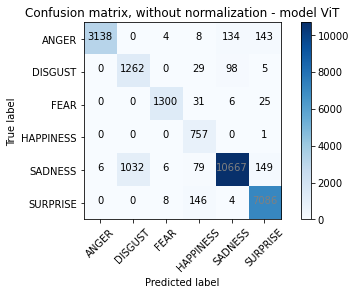

In [56]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=cls_names, title='Confusion matrix, without normalization - model ViT')
plt.show()
plt.close()

Normalized confusion matrix
[[0.916 0.    0.001 0.002 0.039 0.042]
 [0.    0.905 0.    0.021 0.07  0.004]
 [0.    0.    0.954 0.023 0.004 0.018]
 [0.    0.    0.    0.999 0.    0.001]
 [0.001 0.086 0.001 0.007 0.893 0.012]
 [0.    0.    0.001 0.02  0.001 0.978]]


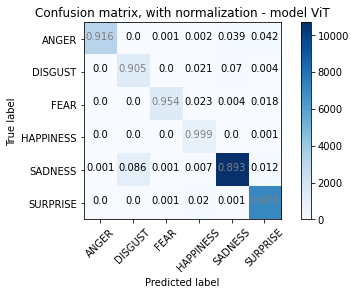

In [57]:
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, classes=cls_names, title='Confusion matrix, with normalization - model ViT')
plt.show()
plt.close()

In [10]:
model.load_state_dict(torch.load("model_main_vit_3_final/model_vit_main_main_lr_0_00003_state_dict.pt", map_location='cuda:0'))
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_fea

In [11]:
#evaluate_accuracy_gpu(model, test_loader, feature_extractor)

In [12]:
test_f1, y_t, y_h_t = evaluate_f1_gpu(model, test_loader, feature_extractor)

In [29]:
test_f1

0.9457880961547341

In [30]:
test_f1

0.9457880961547341

In [31]:
all_f1s_test = f1_score(y_t, y_h_t, average=None)

In [32]:
all_f1s_test

array([0.9895, 0.8467, 0.9433, 0.9305, 0.9763, 0.9885])

In [20]:
sklearn.metrics.accuracy_score(y_t, y_h_t)

0.9711376512019598

In [21]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_t, y_h_t)
np.set_printoptions(precision=4)

In [22]:
cls_names = ['ANGER', 'DISGUST', 'FEAR', 'HAPPINESS', 'SADNESS', 'SURPRISE']

Confusion matrix, without normalization
[[ 3385     0    16     0     9    17]
 [    0  1193    10    19   171     1]
 [    0     0  1357     0     5     0]
 [    0     0     0   756     0     2]
 [   15   231    61    51 11566    15]
 [   15     0    71    41     4  7113]]


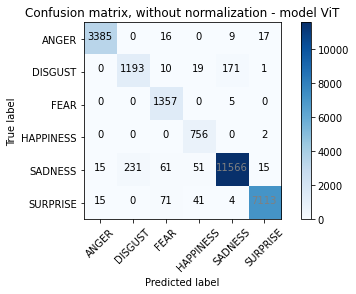

In [25]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=cls_names, title='Confusion matrix, without normalization - model ViT')
plt.show()
plt.close()

Normalized confusion matrix
[[0.988 0.    0.005 0.    0.003 0.005]
 [0.    0.856 0.007 0.014 0.123 0.001]
 [0.    0.    0.996 0.    0.004 0.   ]
 [0.    0.    0.    0.997 0.    0.003]
 [0.001 0.019 0.005 0.004 0.969 0.001]
 [0.002 0.    0.01  0.006 0.001 0.982]]


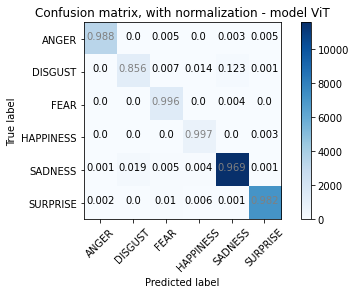

In [26]:
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, classes=cls_names, title='Confusion matrix, with normalization - model ViT')
plt.show()
plt.close()

In [69]:
model.load_state_dict(torch.load("model_main_vit_4/model_vit_main_main_lr_0_00004_state_dict.pt", map_location='cuda:0'))
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_fea

In [70]:
#evaluate_accuracy_gpu(model, test_loader, feature_extractor)

In [71]:
test_f1, y_t, y_h_t = evaluate_f1_gpu(model, test_loader, feature_extractor)

In [72]:
test_f1

0.8379231620782784

In [73]:
all_f1s_test = f1_score(y_t, y_h_t, average=None)

In [74]:
all_f1s_test

array([0.9696, 0.6343, 0.9709, 0.5908, 0.9183, 0.9438])

In [75]:
sklearn.metrics.accuracy_score(y_t, y_h_t)

0.8967233195529015

In [76]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_t, y_h_t)
np.set_printoptions(precision=4)

In [77]:
cls_names = ['ANGER', 'DISGUST', 'FEAR', 'HAPPINESS', 'SADNESS', 'SURPRISE']

Confusion matrix, without normalization
[[ 3408     0     0    12     5     2]
 [    0  1272     0    62    60     0]
 [   28     0  1316    18     0     0]
 [    0     0     0   758     0     0]
 [  155  1345    28   213 10192     6]
 [   12     0     5   745     2  6480]]


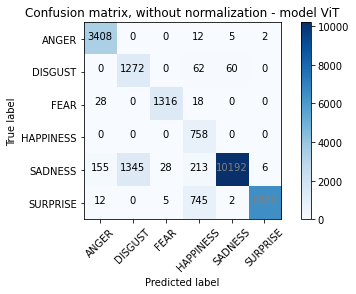

In [78]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=cls_names, title='Confusion matrix, without normalization - model ViT')
plt.show()
plt.close()

Normalized confusion matrix
[[0.994 0.    0.    0.004 0.001 0.001]
 [0.    0.912 0.    0.044 0.043 0.   ]
 [0.021 0.    0.966 0.013 0.    0.   ]
 [0.    0.    0.    1.    0.    0.   ]
 [0.013 0.113 0.002 0.018 0.854 0.001]
 [0.002 0.    0.001 0.103 0.    0.895]]


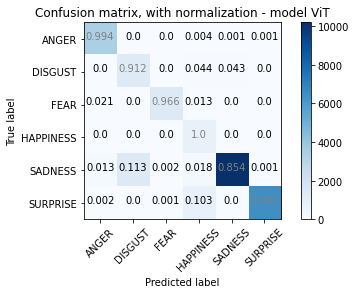

In [79]:
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, classes=cls_names, title='Confusion matrix, with normalization - model ViT')
plt.show()
plt.close()

In [9]:
ds_test = myDataset_1(np.load('test_x.npy'), np.load('test_y.npy'))
test_loader  = data.DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
model.load_state_dict(torch.load("model_main_lr_0_001/model_vit_lr_0_001_state_dict.pt", map_location='cuda:0'))
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_fea

In [11]:
#evaluate_accuracy_gpu(model, test_loader, feature_extractor)

In [12]:
test_f1, y_t, y_h_t = evaluate_f1_gpu(model, test_loader, feature_extractor)

In [13]:
test_f1

0.989900210058482

In [14]:
all_f1s_test = f1_score(y_t, y_h_t, average=None)

In [15]:
all_f1s_test

array([0.9909475 , 0.98181818, 0.99831933, 0.98965705, 0.99230177,
       0.98635744])

In [21]:
sklearn.metrics.accuracy_score(y_t, y_h_t)

0.990286771507863

In [22]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_t, y_h_t)
np.set_printoptions(precision=4)

In [23]:
cls_names = ['ANGER', 'DISGUST', 'FEAR', 'HAPPINESS', 'SADNESS', 'SURPRISE']

Confusion matrix, without normalization
[[ 821    0    0    1    0    1]
 [   0  243    0    0    3    0]
 [   0    0  297    1    0    0]
 [   1    0    0  909    1    0]
 [   7    6    0    2 1289    0]
 [   5    0    0   13    1  723]]


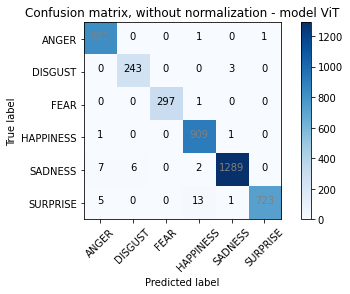

In [24]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=cls_names, title='Confusion matrix, without normalization - model ViT')
plt.show()
plt.close()

Normalized confusion matrix
[[0.998 0.    0.    0.001 0.    0.001]
 [0.    0.988 0.    0.    0.012 0.   ]
 [0.    0.    0.997 0.003 0.    0.   ]
 [0.001 0.    0.    0.998 0.001 0.   ]
 [0.005 0.005 0.    0.002 0.988 0.   ]
 [0.007 0.    0.    0.018 0.001 0.974]]


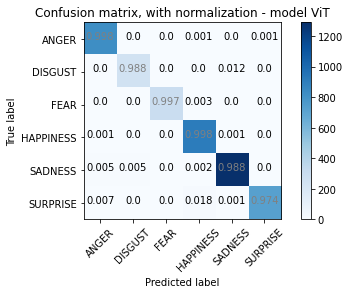

In [25]:
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, classes=cls_names, title='Confusion matrix, with normalization - model ViT')
plt.show()
plt.close()